In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#importing data
df = pd.read_csv('Telco-Customer-Churn.csv')

In [2]:
#A first look at the data
print(df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum())

(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

In [3]:
#Handling the incorrect data
#convert totalcharges to numeric, forching errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

#checking how many null values wee created
print(df['TotalCharges'].isnull().sum())

#Fill the NaN with 0 (New customer who hasnt been charged)
df['TotalCharges'].fillna(0, inplace = True)

11


C:\Users\ELITEX21012G2\AppData\Local\Temp\ipykernel_4104\2618332095.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace = True)


Churn
No     5174
Yes    1869
Name: count, dtype: int64


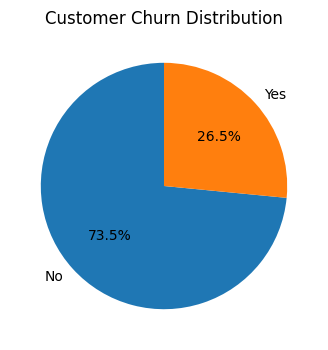

In [4]:
#Exploring the Target Variable
#check for class imbalance
churn_counts = df['Churn'].value_counts()
print(churn_counts)

#visualization
plt.figure(figsize=(6,4))
plt.pie(churn_counts, labels=churn_counts.index, autopct = '%1.1f%%', startangle = 90)
plt.title('Customer Churn Distribution')
plt.show()

# Insight
There is significant class imbalance (5000 retained vs 2000 churned). This is normal in churn problems. We account for this later using stratification in train-test split or class weights in the model.

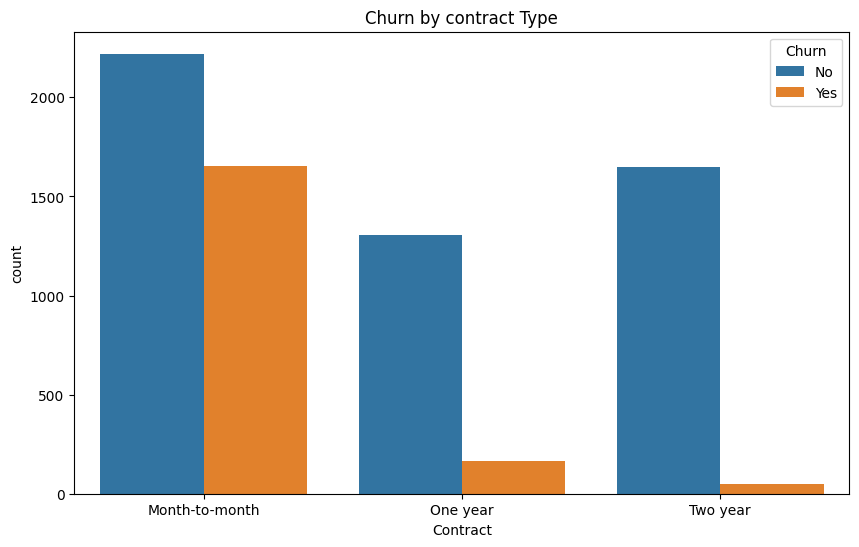

In [5]:
#Explorte Relationship Between Features and Churn:
#Creating visualization to see what drives churn.

#Categorical Features 
plt.figure(figsize= (10,6))
sns.countplot(data = df, x ='Contract', hue ='Churn')
plt.title('Churn by contract Type')
plt.show()

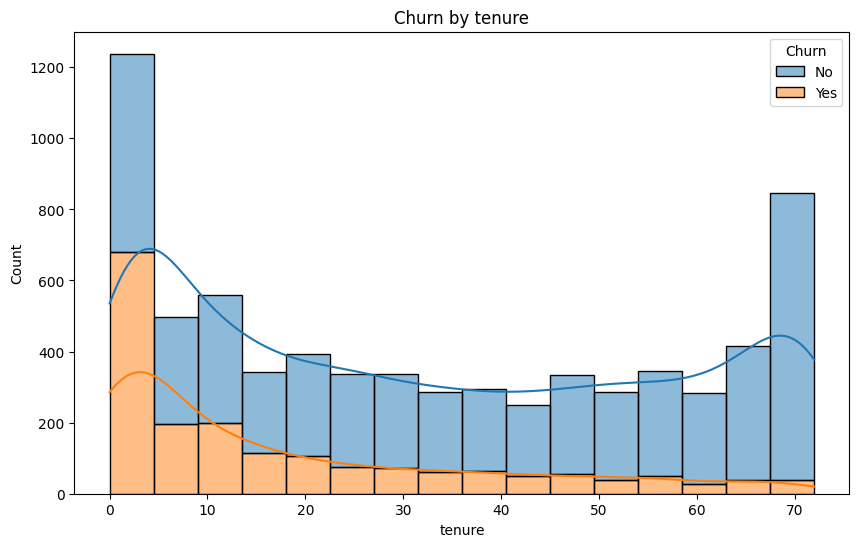

In [6]:
plt.figure(figsize = (10,6))
sns.histplot(data = df, x = 'tenure', hue ='Churn', multiple='stack', kde = True)
plt.title('Churn by tenure')
plt.show()

# Insight
New customer (with low tenure), are more likely to churn as compared to Loyal Customers (with high tenure) who present with more stability.

In [7]:
#3 Data Processing for Machine Learning
#Encode Categorical Variables

df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['Partner'] =df['Partner'].map({'Yes':1,'No':0})
df['Dependents'] = df['Dependents'].map({'Yes':1, 'No':0})
df['PhoneService'] = df['PhoneService'].map({'Yes':1, 'No':0})
df['PaperlessBilling'] =df['PaperlessBilling'].map({'Yes':1, 'No':0})
df['Churn'] =df['Churn'].map({'Yes':1, 'No':0})

In [8]:
#Multi-Category Variable using One-Hot Ecoding
df = pd.get_dummies(
    df,
    columns=[
        'MultipleLines',
        'OnlineSecurity',
        'InternetService',
        'OnlineBackup',
        'TechSupport',
        'StreamingTV',
        'StreamingMovies',
        'Contract'
    ],
    drop_first=True   # drops one dummy per feature to avoid multicollinearity
)

In [9]:
#Splitting the data into training data
from sklearn.model_selection import train_test_split

# Seperate features (X) and target (y)
X= df.drop('Churn', axis =1)
y = df['Churn']

#Split data into training (80%) and testing (20%) sets. Use stratification to handle imbalance
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state = 42, stratify = y)

In [10]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler

# Drop non-numeric columns before scaling
non_numeric_cols = ['customerID', 'DeviceProtection', 'PaymentMethod']
X_train_numeric = X_train.drop(columns=non_numeric_cols)
X_test_numeric = X_test.drop(columns=non_numeric_cols)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

In [11]:
# Building and Train Machine Learning Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

dt_model = DecisionTreeClassifier(random_state=42, max_depth=5) # Limit depth to prevent overfitting

#Fitting the model
dt_model.fit(X_train_numeric, y_train)

#Making predictions
y_pred_dt = dt_model.predict(X_test_numeric)

print('Decision Tree Performance:')
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1035
           1       0.69      0.45      0.54       374

    accuracy                           0.80      1409
   macro avg       0.76      0.69      0.71      1409
weighted avg       0.79      0.80      0.78      1409

[[960  75]
 [207 167]]


In [12]:
# Random Forest Classifier:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model.fit(X_train_numeric, y_train)
y_pred_rt = rf_model.predict(X_test_numeric)

print('Random Forest Performance:')
print(classification_report(y_test, y_pred_rt))
print(confusion_matrix(y_test, y_pred_rt))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

[[919 116]
 [193 181]]


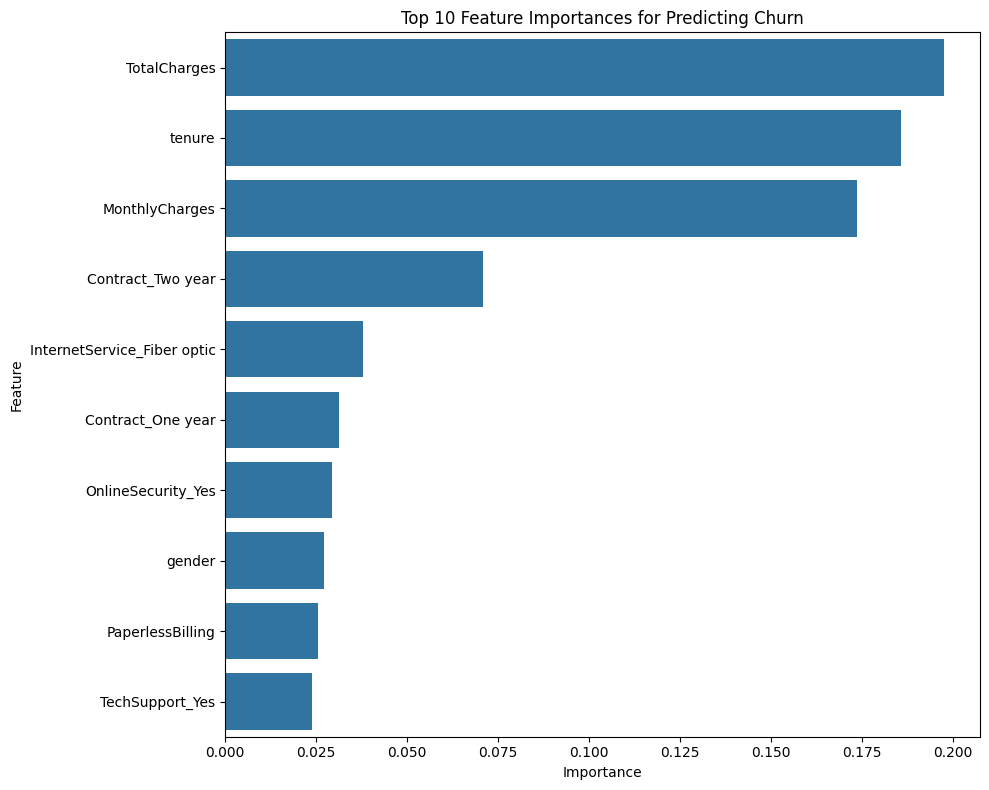

In [13]:
#Evaluate and Interprete the model
# Get Feature importances from the trained Random Forest
importances = rf_model.feature_importances_
feature_names = X_train_numeric.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)

#Plotting the Top 10 most important features
plt.figure(figsize=(10,8))
sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances for Predicting Churn')
plt.tight_layout()
plt.show()

Tenure, totalCharges, Contract_type (month-to-month) and paymentMethod_Electronic check are the top drivers of churn.

### Take Away
The financial factors dominate(charges + tenure). This is price and value perception problem more than the service quality issue. The retention campaigns need to focus heavily on demostrating value and potentially offering pricing adjustments for high-risk customers.

In [14]:
# Making a prediction for a single customer
# create a sample new customer data point (using the same structure as X_train_numeric)

new_customer_numeric = pd.DataFrame({
    'gender': [1],
    'SeniorCitizen': [0],
    'Partner': [0],
    'Dependents': [0],
    'tenure': [5],
    'PhoneService': [1],
    'PaperlessBilling': [1],
    'MonthlyCharges': [70.5],
    'TotalCharges': [70.5],
    'MultipleLines_No phone service': [False],
    'MultipleLines_Yes': [False],
    'OnlineSecurity_No internet service': [False],
    'OnlineSecurity_Yes': [False],
    'InternetService_Fiber optic': [False],
    'InternetService_No': [True],
    'OnlineBackup_No internet service': [False],
    'OnlineBackup_Yes': [False],
    'TechSupport_No internet service': [False],
    'TechSupport_Yes': [False],
    'StreamingTV_No internet service': [False],
    'StreamingTV_Yes': [False],
    'StreamingMovies_No internet service': [False],
    'StreamingMovies_Yes': [False],
    'Contract_One year': [False],
    'Contract_Two year': [False]
}, columns=X_train_numeric.columns)

# Scale the new customer data
new_customer_scaled = scaler.transform(new_customer_numeric)

# Use the model to predict probability
churn_probability = rf_model.predict_proba(new_customer_numeric)[0][1]
print(f'This new customer has a {churn_probability:.2%} probability of churning')
# A high probability would flag them for the retention team

This new customer has a 40.00% probability of churning


### Risk Assessment
This is above average risk. Most telecome companies see 15-25% annual churn rates. While there is no need for urgent panic, this definately requires intervention. 

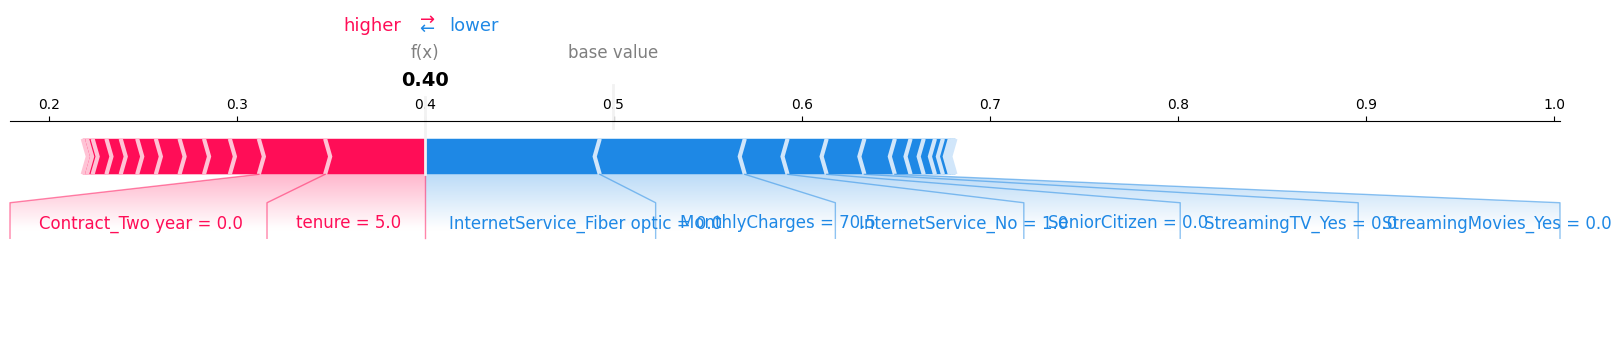

In [15]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(new_customer_numeric)

# For a single instance, shap_values is (features, 2) where 2 is the number of classes
# We want the SHAP values for class 1
shap_values_class1 = shap_values[0][:, 1]

shap.force_plot(explainer.expected_value[1],
                shap_values_class1,
                new_customer_numeric.iloc[0], # Get the feature values for the first instance
                matplotlib=True)

Creating a Retention Simulator

In [16]:
#Step 1:Creating a recommendation Function

import numpy as np

def get_retention_recommendation(model, customer_data, probability_threshold_high=0.5, probability_threshold_medium=0.2):
    """
    Takes a trained model and a single customer's data.
    Returns a prediction, a reason, and a personalized retention strategy.
    """
    
    # Get the basic prediction
    churn_prob = model.predict_proba(customer_data)[0][1]
    
    # Get SHAP values to explain the prediction
    explainer = shap.TreeExplainer(model.named_steps['classifier']) # Access the model from the pipeline
    # Important: We need to preprocess the customer data exactly like the pipeline does
    processed_data = model.named_steps['preprocessor'].transform(customer_data)
    shap_values = explainer.shap_values(processed_data)
    
    # For a single instance, get the values for the positive (churn) class
    if isinstance(shap_values, list):
        shap_values_instance = shap_values[1][0] # Handle list output for binary classification
    else:
        shap_values_instance = shap_values[0] # Handle single array output
    
    # Get feature names after preprocessing (this can be tricky with OneHotEncoder)
    # This is a simplified approach. For a full solution, you'd map feature names from the preprocessor.
    feature_names = customer_data.columns.tolist() # This might not be perfect but works for demo
    
    # Find the top feature that INCREASES the churn risk (largest positive SHAP value)
    top_risk_index = np.argmax(shap_values_instance)
    top_risk_feature = feature_names[top_risk_index]
    top_risk_value = customer_data.iloc[0][top_risk_index]
    
    # Define action based on probability
    if churn_prob >= probability_threshold_high:
        action = "IMMEDIATE PHONE CALL from retention specialist."
        offer = "Offer a 20% discount and a free premium service upgrade (e.g., Streaming TV) for 6 months to lock them into a one-year contract."
        urgency = "high"
    elif churn_prob >= probability_threshold_medium:
        action = "Add to targeted email campaign sequence."
        offer = "Offer a 10% discount on their next bill. Highlight the benefits of their current plan or suggest a more suitable, cheaper plan."
        urgency = "medium"
    else:
        action = "No action required. Monitor."
        offer = "N/A"
        urgency = "low"
    
    # Create a human-readable reason
    reason = f"Primary risk factor: {top_risk_feature} is {top_risk_value}."
    
    # Create a dictionary with all information
    recommendation = {
        'churn_probability': churn_prob,
        'urgency': urgency,
        'action': action,
        'personalized_offer': offer,
        'primary_reason': reason,
        'shap_values': shap_values_instance # Optional: pass the values for further analysis
    }
    
    return recommendation

In [17]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import plotly.express as px
import plotly.graph_objects as go

# Page configuration
st.set_page_config(
    page_title="Customer Churn Prediction",
    page_icon="📊",
    layout="wide"
)

# Title and description
st.title("🔮 Customer Churn Prediction Dashboard")
st.markdown("Predict customer churn risk and get personalized retention strategies")

# Sidebar for input features
st.sidebar.header("📋 Customer Information")

def get_user_input():
    """Collect user input for prediction"""
    
    # Demographics
    st.sidebar.subheader("Demographics")
    age = st.sidebar.slider("Age", 18, 80, 35)
    gender = st.sidebar.selectbox("Gender", ["Male", "Female"])
    
    # Account Information
    st.sidebar.subheader("Account Details")
    tenure = st.sidebar.slider("Tenure (months)", 0, 72, 24)
    contract_type = st.sidebar.selectbox("Contract Type", ["Month-to-month", "One year", "Two year"])
    payment_method = st.sidebar.selectbox("Payment Method", 
                                        ["Electronic check", "Mailed check", "Bank transfer", "Credit card"])
    
    # Services
    st.sidebar.subheader("Services")
    monthly_charges = st.sidebar.slider("Monthly Charges ($)", 20.0, 120.0, 65.0)
    total_charges = st.sidebar.number_input("Total Charges ($)", 20.0, 8500.0, tenure * monthly_charges)
    
    # Service usage
    phone_service = st.sidebar.checkbox("Phone Service", True)
    internet_service = st.sidebar.selectbox("Internet Service", ["No", "DSL", "Fiber optic"])
    online_security = st.sidebar.checkbox("Online Security")
    tech_support = st.sidebar.checkbox("Tech Support")
    streaming_tv = st.sidebar.checkbox("Streaming TV")
    
    # Support interactions
    st.sidebar.subheader("Support History")
    support_calls = st.sidebar.slider("Support Calls (last 3 months)", 0, 10, 2)
    
    # Create feature dictionary
    features = {
        'age': age,
        'gender': gender,
        'tenure': tenure,
        'contract_type': contract_type,
        'payment_method': payment_method,
        'monthly_charges': monthly_charges,
        'total_charges': total_charges,
        'phone_service': int(phone_service),
        'internet_service': internet_service,
        'online_security': int(online_security),
        'tech_support': int(tech_support),
        'streaming_tv': int(streaming_tv),
        'support_calls': support_calls
    }
    
    return features

def preprocess_input(features):
    """Convert user input to model-ready format"""
    # Create DataFrame
    df = pd.DataFrame([features])
    
    # Encode categorical variables (simplified - in real app, use fitted encoders)
    df['gender_encoded'] = df['gender'].map({'Male': 0, 'Female': 1})
    df['contract_encoded'] = df['contract_type'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
    df['payment_encoded'] = df['payment_method'].map({
        'Electronic check': 0, 'Mailed check': 1, 'Bank transfer': 2, 'Credit card': 3
    })
    df['internet_encoded'] = df['internet_service'].map({'No': 0, 'DSL': 1, 'Fiber optic': 2})
    
    # Select features for prediction
    feature_cols = ['age', 'tenure', 'monthly_charges', 'total_charges', 'phone_service',
                   'online_security', 'tech_support', 'streaming_tv', 'support_calls',
                   'gender_encoded', 'contract_encoded', 'payment_encoded', 'internet_encoded']
    
    return df[feature_cols]

def create_mock_model():
    """Create a mock model for demonstration (replace with your trained model)"""
    # This is a placeholder - load your actual trained model here
    np.random.seed(42)
    
    class MockChurnModel:
        def predict_proba(self, X):
            # Mock prediction based on some logical rules
            df = X.iloc[0] if hasattr(X, 'iloc') else X
            
            risk_score = 0.2  # Base risk
            
            # Add risk factors
            if df['contract_encoded'] == 0:  # Month-to-month
                risk_score += 0.3
            if df['tenure'] < 12:  # New customer
                risk_score += 0.2
            if df['support_calls'] > 3:  # High support calls
                risk_score += 0.25
            if df['monthly_charges'] > 80:  # High charges
                risk_score += 0.15
            if df['payment_encoded'] == 0:  # Electronic check
                risk_score += 0.1
            
            risk_score = min(risk_score, 0.95)  # Cap at 95%
            return np.array([[1-risk_score, risk_score]])
    
    return MockChurnModel()

def get_retention_recommendation(features, churn_prob):
    """Generate personalized retention recommendations"""
    
    urgency = "low"
    if churn_prob > 0.7:
        urgency = "high"
    elif churn_prob > 0.4:
        urgency = "medium"
    
    # Analyze key risk factors
    reasons = []
    actions = []
    
    if features['contract_type'] == "Month-to-month":
        reasons.append("month-to-month contract increases churn risk")
        actions.append("Offer annual contract with discount")
    
    if features['tenure'] < 12:
        reasons.append("new customer with higher churn probability")
        actions.append("Provide onboarding support and check-in calls")
    
    if features['support_calls'] > 3:
        reasons.append("high number of recent support calls")
        actions.append("Proactive technical support and service review")
    
    if features['monthly_charges'] > 80:
        reasons.append("high monthly charges may indicate price sensitivity")
        actions.append("Review service bundle and offer cost optimization")
    
    # Generate personalized offer
    offers = {
        "high": f"Priority support + 20% discount for 12-month commitment",
        "medium": f"Free premium feature trial + 10% discount for 6 months",
        "low": f"Loyalty reward points + exclusive customer perks"
    }
    
    primary_reason = reasons[0] if reasons else "standard risk factors"
    recommended_action = actions[0] if actions else "standard retention outreach"
    
    return {
        'urgency': urgency,
        'primary_reason': primary_reason,
        'action': recommended_action,
        'personalized_offer': offers[urgency],
        'risk_factors': reasons
    }

def create_risk_visualization(churn_prob):
    """Create risk level visualization"""
    fig = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = churn_prob * 100,
        domain = {'x': [0, 1], 'y': [0, 1]},
        title = {'text': "Churn Risk %"},
        gauge = {
            'axis': {'range': [None, 100]},
            'bar': {'color': "darkblue"},
            'steps': [
                {'range': [0, 30], 'color': "lightgreen"},
                {'range': [30, 60], 'color': "yellow"},
                {'range': [60, 100], 'color': "red"}
            ],
            'threshold': {
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': 70
            }
        }
    ))
    fig.update_layout(height=400)
    return fig

# Main app logic
def main():
    # Get user input
    features = get_user_input()
    
    # Main content area
    col1, col2 = st.columns([2, 1])
    
    with col1:
        st.subheader("Customer Profile")
        
        # Display customer summary
        profile_data = {
            "Attribute": ["Age", "Tenure", "Contract Type", "Monthly Charges", "Total Charges"],
            "Value": [features['age'], f"{features['tenure']} months", 
                     features['contract_type'], f"${features['monthly_charges']:.2f}", 
                     f"${features['total_charges']:.2f}"]
        }
        st.table(pd.DataFrame(profile_data))
    
    with col2:
        if st.button('🔮 Predict Churn Risk', type="primary"):
            # Process input and make prediction
            processed_features = preprocess_input(features)
            model = create_mock_model()  # Replace with your actual model
            prediction_proba = model.predict_proba(processed_features)[0][1]
            churn_percent = prediction_proba * 100
            
            # Get recommendations
            recommendation = get_retention_recommendation(features, prediction_proba)
            
            # Display results
            st.subheader(f"📊 Churn Risk: {churn_percent:.1f}%")
            
            # Risk level indicator
            if recommendation['urgency'] == 'high':
                st.error('🚨 HIGH RISK - Immediate Action Required')
            elif recommendation['urgency'] == 'medium':
                st.warning('⚠️ MEDIUM RISK - Monitor Closely')
            else:
                st.success('✅ LOW RISK - Routine Follow-up')
            
            # Visualization
            st.plotly_chart(create_risk_visualization(prediction_proba), use_container_width=True)
            
            # Detailed analysis
            with st.expander("📋 Detailed Analysis & Recommendations"):
                st.markdown(f"**Primary Risk Factor:** {recommendation['primary_reason']}")
                st.markdown(f"**Recommended Action:** {recommendation['action']}")
                st.markdown(f"**Suggested Offer:** {recommendation['personalized_offer']}")
                
                if recommendation['risk_factors']:
                    st.markdown("**All Risk Factors:**")
                    for factor in recommendation['risk_factors']:
                        st.write(f"• {factor}")
            
            # Action items
            st.subheader("🎯 Next Steps")
            if recommendation['urgency'] == 'high':
                st.write("1. 📞 Contact customer within 24 hours")
                st.write("2. 🎁 Present retention offer")
                st.write("3. 📝 Schedule follow-up in 1 week")
            elif recommendation['urgency'] == 'medium':
                st.write("1. 📧 Send personalized email campaign")
                st.write("2. 📊 Monitor usage patterns")
                st.write("3. 📅 Schedule check-in call in 2 weeks")
            else:
                st.write("1. ✅ Add to standard loyalty program")
                st.write("2. 📈 Continue regular engagement")
                st.write("3. 🔄 Re-evaluate in 3 months")

# Run the app
if __name__ == "__main__":
    main()

2025-09-16 17:46:51.810 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-16 17:46:51.835 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-16 17:46:55.580 
  command:

    streamlit run c:\Users\ELITEX21012G2\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-16 17:46:55.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-16 17:46:55.586 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-16 17:46:55.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-16 17:46:55.592 Thread 'MainThread': missing ScriptRunContext!

In [18]:
# Replace the mock model with something like:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Use existing train data
# X_train and y_train are already defined

# Train your model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100))
])
pipeline.fit(X_train_numeric, y_train)

# Save the model
import joblib
joblib.dump(pipeline, 'churn_model.pkl')

['churn_model.pkl']

In [19]:
import joblib
import os

# Load your model
parent_dir = r"C:\Users\ELITEX21012G2\Documents\Customer churn Prediction Project"
pkl_files = [f for f in os.listdir(parent_dir) if f.endswith('.pkl')]
model_path = os.path.join(parent_dir, pkl_files[0])
model = joblib.load(model_path)

# Check feature names
if hasattr(model, 'feature_names_in_'):
    print("Expected features:")
    for i, feature in enumerate(model.feature_names_in_):
        print(f"{i+1}. {feature}")
elif hasattr(model, 'steps'):
    # If it's a pipeline, check the last step
    final_step = model.steps[-1][1]
    if hasattr(final_step, 'feature_names_in_'):
        print("Expected features:")
        for i, feature in enumerate(final_step.feature_names_in_):
            print(f"{i+1}. {feature}")

Expected features:
1. gender
2. SeniorCitizen
3. Partner
4. Dependents
5. tenure
6. PhoneService
7. PaperlessBilling
8. MonthlyCharges
9. TotalCharges
10. MultipleLines_No phone service
11. MultipleLines_Yes
12. OnlineSecurity_No internet service
13. OnlineSecurity_Yes
14. InternetService_Fiber optic
15. InternetService_No
16. OnlineBackup_No internet service
17. OnlineBackup_Yes
18. TechSupport_No internet service
19. TechSupport_Yes
20. StreamingTV_No internet service
21. StreamingTV_Yes
22. StreamingMovies_No internet service
23. StreamingMovies_Yes
24. Contract_One year
25. Contract_Two year
